In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

import dill
import seaborn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def MalhaRetangular(N):
   Δ = 10.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(-5.0,5.0+Δx,Δx)
   y = API_Numpy.arange(-1.0,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

def CondiçãoInicialShockEntropy2D(X, Y, γ,θ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.ones(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)

   I = API_Numpy.ones(X.shape)

   l=X < -4
   r=X >=-4

   R[l]=I[l]*27.0/7.0
   U[l]=I[l]*4.0*API_Numpy.sqrt(35.0)/9.0
   P[l]=I[l]*31.0/3.0

   R[r] = 1.0 + API_Numpy.sin(X[r]*API_Numpy.cos(θ)*2.0*API_Numpy.pi + Y[r]*API_Numpy.sin(θ)*2.0*API_Numpy.pi)/5.0

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   return Q0

def CondiçãoInicialShockEntropy2D_N(N, γ,θ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialShockEntropy2D(X, Y, γ,θ)
   return X, Y, Δ, Q0

def NullForce(Q,API):
   return 0.0

In [35]:
class ShockEntropy2DGhostPointsX:
    def __init__(self,γ,Δx,y,θ):
        self.γ=γ
        self.Δx=Δx
        self.y=y
        self.θ=θ
    def __call__(self,Q,API):
        ρl = 27.0/7.0
        ul = 4.0*API.cast(API.sqrt(35.0),'float64')/9.0
        pl = 31.0/3.0
        El = pl/(γ-1.0) + ρl*(ul**2)/2.0
        El = API.cast(El,'float64')

        raw_ref_shape=API.shape(Q)[:-3]
        out_shape=API.concat([API.shape(Q)[:-2],[3],API.shape(Q)[-1:]],axis=0)
        ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)

        vals_left=API.reshape([ρl, ρl*ul, 0.0, El],ref_shape)

        Xr = API.reshape([5.0+self.Δx, 5.0+2*self.Δx, 5.0+3*self.Δx], [3, 1])
        Yr = self.y[...,:3,:]
        ρr = 1.0 + API.sin(5.0*Xr*API.cos(self.θ) + 5.0*Yr*API.sin(self.θ))/5.0
        pr = API.ones(ρr.shape)
        ur = API.zeros(ρr.shape)
        vr = API.zeros(ρr.shape)
        Er = pr/(self.γ-1.0)
        Qr = API.stack([ρr, ur, vr, Er],axis=-3)

        Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
        Q,
        API.cast(Qr,'float64')]

        return API.concat(Qg,-2)

def ShockEntropy2DGhostPointsY(Q,API):
    Qg = API.concat(
        [Q[...,:,-3:],
            Q,
            Q[...,:,:3]],axis=-1)
    return Qg

In [106]:
γ = 7.0/5.0
θ = API_Numpy.pi/6.0
N = 400
x, y, Δ, U0 = CondiçãoInicialShockEntropy2D_N(N, γ,θ)
Δx=Δ
cfl = 0.5
t_final = 0.01

GhostPointsX=ShockEntropy2DGhostPointsX(γ,Δx,y,θ)

In [107]:
WENO_Z_sim=simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        ε=1e-40)

In [108]:
t=0
count=0
U=U0.copy()
while t<t_final:
    Λ  = WENO_Z_sim.equation.maximum_speed(U)
    Δt = Δ*cfl/Λ
    Δt = np.where(t+Δt>t_final,t_final-t,Δt)

    U=WENO_Z_sim.Sim_step(U, Δt, Δ, Δ, GhostPointsX, ShockEntropy2DGhostPointsY,NullForce)
    t+=Δt
    print(t,end='\r')

In [110]:
import h5py

f = h5py.File("data_julia.jld", "r")
data_julia=np.asarray(f['data']).transpose((0,2,1))

0.21479520001339658


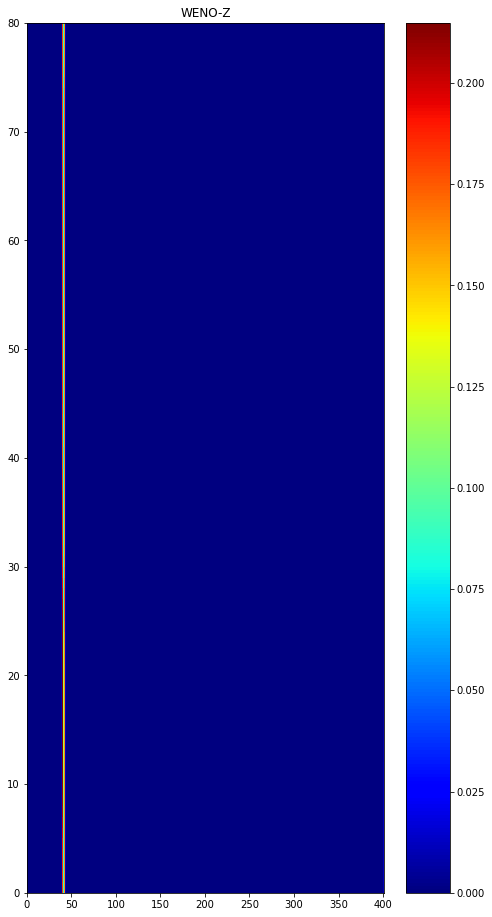

In [111]:
plt.figure(figsize=(8,16))
ref_U=np.abs(U[0]-data_julia[0])
print(np.max(ref_U))
a=plt.pcolormesh(ref_U.T,cmap='jet')
plt.colorbar(a)
plt.title('WENO-Z')
plt.show()

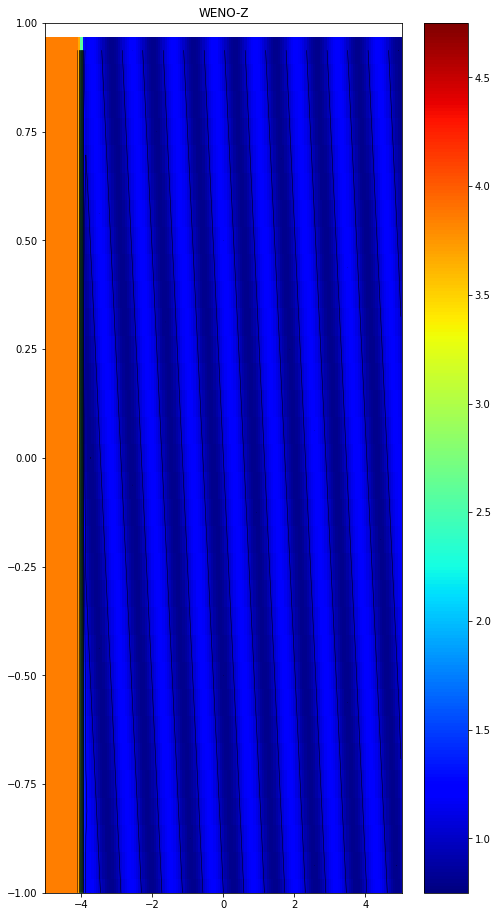

In [8]:
plt.figure(figsize=(8,16))
ref_U=U[0].numpy()
a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
plt.colorbar(a)
plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
plt.title('WENO-Z')
plt.ylim((-1,1))
plt.show()

In [47]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0
    if not(os.path.isdir(f'imagens/shockdensity2D-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-{name}/')
    if not(os.path.isdir(f'imagens/shockdensity2D-Zoom-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-Zoom-{name}/')
    while t<t_final:
        Λ  = WENO_type.equation.maximum_speed(U)
        Δt = Δ*cfl/Λ
        Δt = np.where(t+Δt>t_final,t_final-t,Δt)

        U=WENO_type.Sim_step(U, Δt, Δ, Δ, ShockEntropy2DGhostPointsX, ShockEntropy2DGhostPointsY,NullForce)
        t+=Δt
        print(t,end='\r')
        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-{name}/{count}.png')
        plt.close()

        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-Zoom-{name}/{count}.png')
        plt.close()

    with open(name+'.bkp','wb') as file:
        dill.dump(U,file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    plt.xlim((0,3))
    plt.savefig('shockdensity2D-zoom'+name+'.png')
    plt.close()

In [44]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0

    with open(name+'.bkp','rb') as file:
        U=dill.load(file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

In [18]:
API_Numpy.min(ref_U)

0.7887306367423698